# CODIGO A EJECUTAR

## Valor del grosor de la capa de concreto superior B1=0,07 m

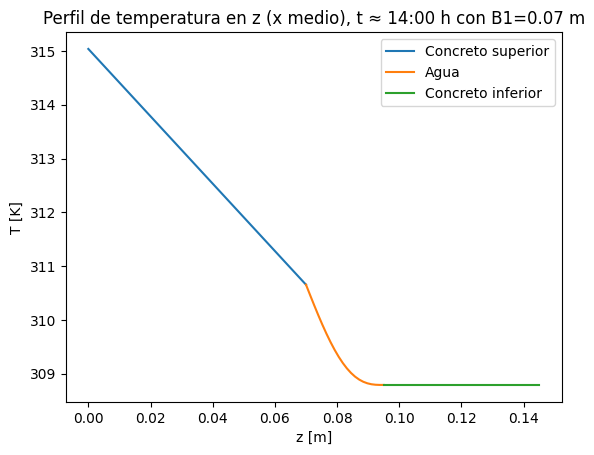

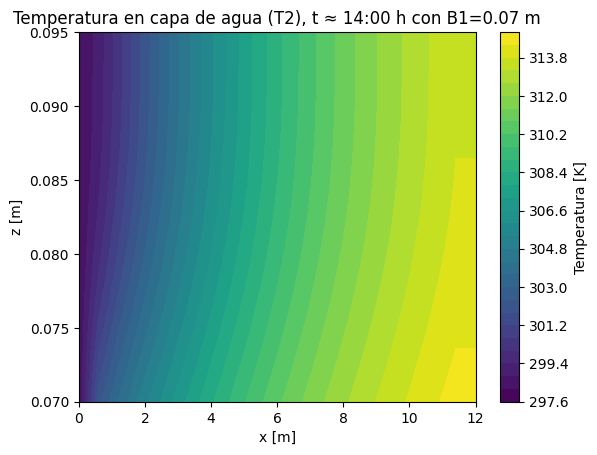

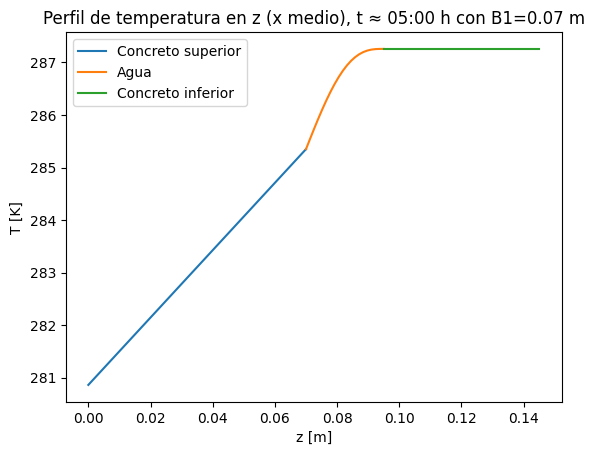

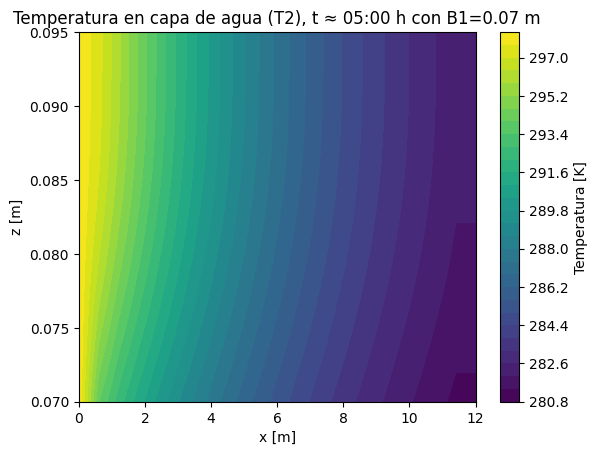

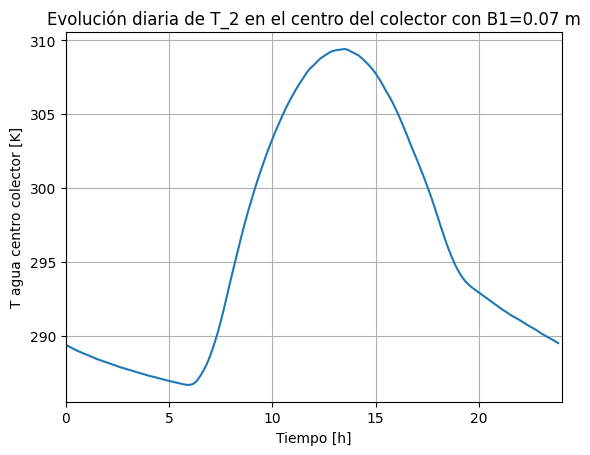

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================
#                    PARÁMETROS DEL MODELO
# ============================================================

#-------------------------------------------------------------
#······················· Geométricos: ························

L = 12          # Largo [m]
B1 = 0.07       # Espesor concreto superior [m]
B2 = 0.025      # Espesor agua [m]
B3 = 0.05       # Espesor concreto inferior [m]

#Conductividades:
k1 = 1.4        # Conductividad concreto [W/m·K]
k2 = 0.6        # Conductividad agua [W/m·K]
k3 = 1.4        # Conductividad concreto [W/m·K]

#Densidades
rho1 = 2400     # Densidad concreto superior (no se usa) Kg/m^3
rho2 = 997      # Densidad agua Kg/m^3
rho3 = 2400     # Densidad concreto inferior (no se usa) Kg/m^3

#Calores específicos:
cp1  = 1000     # Calor especifico concreto superior (no se usa) J/Kg*K
cp2  = 4186     # Calor especifico agua J/Kg*K
cp1  = 1000     # Calor especifico concreto inferior (no se usa) J/Kg*K

#Otros:
v_max = 0.001   # Velocidad máxima agua [m/s]
Tin   = 298.15  # T entrada agua K
h     = 25    # Coef. conveccion aire W/m^2*K
alpha = 0.6     # Absortancia del concreto

#-------------------------------------------------------------
#············ Perfil de velocidad vx(z) parabólico ···········

def v_x_water(z):
    """ACA CAMBIO
    return 4 * v_max / (B2**2) * (z - B1) * (B1 + B2 - z)"""
    return max(0, 4 * v_max / (B2**2) * (z - B1) * (B1 + B2 - z))

#-------------------------------------------------------------
#············ Parámetros dependientes del tiempo ·············

df = pd.read_csv("G(t)_T(t)_FdT.csv", sep=';', decimal=',')
G_serie = df["G(t)"].values # Flujo solar incidente W/m^2
T_serie = df["T(t) [K]"].values # T ambiente
t_serie = df["t"].values  # fracción de día

dt = 600.0  # segundos = 10 minutos

for n in range(len(G_serie)):
    G = G_serie[n]
    T_inf = T_serie[n]
    t_fisico = n * dt  # otra ocpión sería usar t[n] que sería fracción de día
    # resolver con (G, T_infy, ...)

#PAra más comodidad:
df = df.rename(columns={"G(t)": "G", "T(t) [ºC]": "T_C", "T(t) [K]": "T_K"})
#así se usaría df["G"], df["T_K"] , etc...

#-------------------------------------------------------------
#············ Parámetros para la Foto del sistema ············

# Elegir el instante más cercano a las 14:00 h
t_obj14 =14/24
idx_14 = np.argmin(np.abs(t_serie-t_obj14))
G_14 =G_serie[idx_14]
T_inf_14 = T_serie[idx_14]
# (usaremos G_14 y T_inf_14 más abajo para la foto del sistema a las 14:00 h)

# Elegir el instante más cercano a las 05:00 h (momento sin radiacón y con más frío aprox )
t_obj5 = 5/24
idx_5 = np.argmin(np.abs(t_serie-t_obj5))
G_5 = G_serie[idx_5]
T_inf_5 =T_serie[idx_5]
# (usaremos G_5 y T_inf_5 más abajo para la foto del sistema a las 05:00 h)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#                  DISCRETIZACIÓN DEL MODELO
# ============================================================

#-------------------------------------------------------------
#······················ nodos y mallas ·······················

Nx  = 21
Nz1 = 20
Nz2 = 20
Nz3 = 20

dx = L / (Nx - 1)
dz1 = B1 / (Nz1 - 1)
dz2 = B2 / (Nz2 - 1)
dz3 = B3 / (Nz3 - 1)

x  = np.linspace(0, L, Nx)
z1  = np.linspace(0, B1, Nz1)
z2  = B1 + np.linspace(0, B2, Nz2)
z3  = B1 + B2 + np.linspace(0, B3, Nz3)

# Nodos totales por capa
N1 = Nx * Nz1
N2 = Nx * Nz2
N3 = Nx * Nz3
Ntot = N1 + N2 + N3

def idx1(i, j):
    return i * Nz1 + j
def idx2(i, j):
    return i * Nz2 + j + N1
def idx3(i, j):
    return i * Nz3 + j + N1 + N2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#             Función Para Tener Foto del Sistema
# ============================================================

def resolver_foto(G_val, T_inf_val): # Resuelve el problema estacionario dado cada valor G y T_inf

    G = G_val
    T_inf = T_inf_val

    A = np.zeros((Ntot, Ntot))
    b = np.zeros(Ntot)

    #··········· Capa 1 Cemento ···········
    for i in range(Nx):
        for j in range(1, Nz1 - 1):
            p = idx1(i, j)
            A[p, idx1(i, j+1)] = -k1 / dz1**2
            A[p, idx1(i, j)]   =  2 * k1 / dz1**2
            A[p, idx1(i, j-1)] = -k1 / dz1**2
            b[p] = 0

    for i in range(Nx):
        p = idx1(i, 0)   # nodo z = 0
        coeff_k = k1 / (2 * dz1)
        A[p, idx1(i, 0)] = 3 * coeff_k + h
        A[p, idx1(i, 1)] = -4 * coeff_k
        A[p, idx1(i, 2)] = coeff_k
        b[p] = alpha * G + h * T_inf

    for i in range(Nx):
        p = idx1(i, Nz1-1)     # último nodo capa 1
        A[p, idx1(i, Nz1-1)] = 1
        A[p, idx2(i, 0)]     = -1     # primer nodo capa 2
        b[p] = 0

    #··········· Capa 2 Agua ···········
    for i in range(1, Nx-1):          # interior x
        for j in range(1, Nz2-1):     # interior z
            p = idx2(i, j)
            vz = v_x_water(z2[j])

            #Término depende de la "dirección" de la información, por lo que el término i depnde del termino i-1

            adv    = rho2 * cp2 * vz / dx
            diff_x = k2 / dx**2
            diff_z = k2 / dz2**2

            A[p, idx2(i, j)]   = adv + 2*diff_x + 2*diff_z
            A[p, idx2(i-1, j)] = -adv - diff_x  # Nodo atrás
            A[p, idx2(i+1, j)] = -diff_x        # Nodo adelante
            A[p, idx2(i, j+1)] = -diff_z        # Arriba
            A[p, idx2(i, j-1)] = -diff_z        # Abajo
            b[p] = 0

    # Interfaz Superior
    for i in range(1, Nx):
        p = idx2(i, 0)
        # k1*(T_int - T1_prev)/dz1 + k2*(T_int - T2_next)/dz2 = 0
        A[p, idx2(i, 0)]     = -(k1/dz1 + k2/dz2)
        A[p, idx1(i, Nz1-2)] = k1/dz1
        A[p, idx2(i, 1)]     = k2/dz2
        b[p] = 0

    # Interfaz Inferior
    # CB4: T2(z = B1 + B2) = T3(z = B1 + B2)
    for i in range(Nx):
        p = idx2(i, Nz2-1)   # último nodo capa 2
        A[p, idx2(i, Nz2-1)] = 1
        A[p, idx3(i, 0)]     = -1  # primer nodo capa 3
        b[p] = 0

    # CB5: T2(x=0, z) = Tin
    for j in range(Nz2):
        p = idx2(0, j)
        A[p, :] = 0  #limpiar fila por si las moscas
        A[p, idx2(0, j)] = 1
        b[p] = Tin

    # CB6: dT2/dz = 0 en x = L
    i_out = Nx - 1
    for j in range(1, Nz2-1):
        p = idx2(i_out, j)
        A[p, idx2(i_out, j)]   = 1
        A[p, idx2(i_out-1, j)] = -1
        b[p] = 0

    #··········· Capa 3 Cemento ···········
    for i in range(Nx):
        for j in range(1, Nz3 - 1):
            p = idx3(i, j)
            A[p, idx3(i, j+1)] = -k3 / dz3**2
            A[p, idx3(i, j)]   =  2 * k3 / dz3**2
            A[p, idx3(i, j-1)] = -k3 / dz3**2
            b[p] = 0


    for i in range(Nx):
        p = idx3(i, 0)
        # k2*(T_int - T2_prev)/dz2 + k3*(T_int - T3_next)/dz3 = 0
        A[p, idx3(i, 0)]     = -(k2/dz2 + k3/dz3)
        A[p, idx2(i, Nz2-2)] = k2/dz2
        A[p, idx3(i, 1)]     = k3/dz3
        b[p] = 0


    # CB8: aislamiento en z = B1 + B2 + B3  => dT3/dz = 0
    j_bot = Nz3 - 1
    for i in range(Nx):
        p = idx3(i, j_bot)
        A[p, idx3(i, j_bot)]   = 3
        A[p, idx3(i, j_bot-1)] = -4
        A[p, idx3(i, j_bot-2)] = 1
        b[p] = 0


    # Resolver A T = b en mínimos cuadrados
    T_vec, *_ = np.linalg.lstsq(A, b, rcond=None)

    # T1, T2, T3 en 2D (x,z)
    T1 = np.zeros((Nx, Nz1))
    T2 = np.zeros((Nx, Nz2))
    T3 = np.zeros((Nx, Nz3))

    for i in range(Nx):
        for j in range(Nz1):
            T1[i, j] = T_vec[idx1(i, j)]
        for j in range(Nz2):
            T2[i, j] = T_vec[idx2(i, j)]
        for j in range(Nz3):
            T3[i, j] = T_vec[idx3(i, j)]

    return T1, T2, T3

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#          Foto del Sistema para las 5:00 y las 14:00
# ============================================================

#-------------------------------------------------------------
#············· "Foto" del sistema en t ≈ 14:00 h ·············

#Resolvemos el modelo usando el G y T_inf de las ~14:00 h
T1, T2, T3 = resolver_foto(G_14, T_inf_14)

# Perfiles en z a la mitad del colector
i_mid = Nx // 2

plt.figure()
plt.plot(z1, T1[i_mid, :], label='Concreto superior')
plt.plot(z2, T2[i_mid, :], label='Agua')
plt.plot(z3, T3[i_mid, :], label='Concreto inferior')
plt.xlabel('z [m]')
plt.ylabel('T [K]')
plt.legend()
plt.title('Perfil de temperatura en z (x medio), t ≈ 14:00 h con B1=0.07 m')  #título
plt.show()

# Mapa de temperatura en la capa de agua (T2)
X, Z2 = np.meshgrid(x, z2, indexing='ij')

plt.figure()
cp = plt.contourf(X, Z2, T2, levels=30)
plt.colorbar(cp, label='Temperatura [K]')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.title('Temperatura en capa de agua (T2), t ≈ 14:00 h con B1=0.07 m')  #Título
plt.show()

#-------------------------------------------------------------
#············· "Foto" del sistema en t ≈ 05:00 h ·············

#Resolvemos el modelo usando el G y T_inf de las ~05:00 h
T1, T2, T3 = resolver_foto(G_5, T_inf_5)

# Perfiles en z a la mitad del colector
i_mid = Nx // 2

plt.figure()
plt.plot(z1, T1[i_mid, :], label='Concreto superior')
plt.plot(z2, T2[i_mid, :], label='Agua')
plt.plot(z3, T3[i_mid, :], label='Concreto inferior')
plt.xlabel('z [m]')
plt.ylabel('T [K]')
plt.legend()
plt.title('Perfil de temperatura en z (x medio), t ≈ 05:00 h con B1=0.07 m')  #título
plt.show()

# Mapa de temperatura en la capa de agua (T2)
X, Z2 = np.meshgrid(x, z2, indexing='ij')

plt.figure()
cp = plt.contourf(X, Z2, T2, levels=30)
plt.colorbar(cp, label='Temperatura [K]')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.title('Temperatura en capa de agua (T2), t ≈ 05:00 h con B1=0.07 m')  #Título
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#  Temperatura del agua en el centro del colector vs tiempo
# ============================================================

# Punto representativo: x = L/2, z ≈ mitad de la capa de agua
i_centro = Nx // 2
j_centro = Nz2 // 2

T_centro = np.zeros_like(G_serie)

for n, (G_val, Tinf_val) in enumerate(zip(G_serie, T_serie)):
    T1_foto, T2_foto, T3_foto = resolver_foto(G_val, Tinf_val)
    T_centro[n] = T2_foto[i_centro, j_centro]

t_horas = t_serie * 24

plt.figure()
plt.plot(t_horas, T_centro)
plt.xlabel('Tiempo [h]')
plt.ylabel('T agua centro colector [K]')
plt.title('Evolución diaria de T_2 en el centro del colector con B1=0.07 m')
plt.grid(True)
plt.xlim(0, 24)
plt.show()


## Valor del grosor de la capa de concreto superior B1= 0,01 m
 Disminuyendo el grosor del cemento superior de 0,07 m a B1=0.01 m

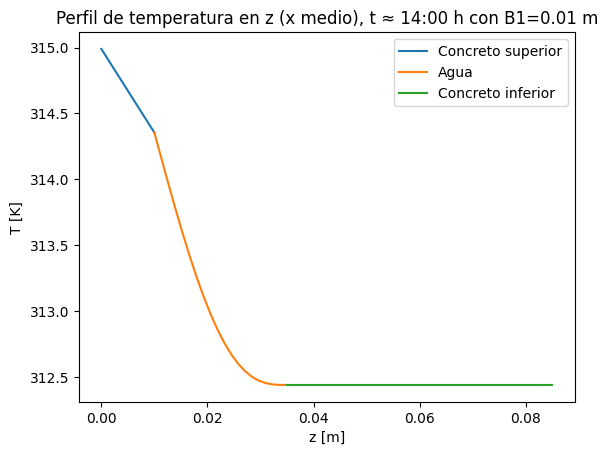

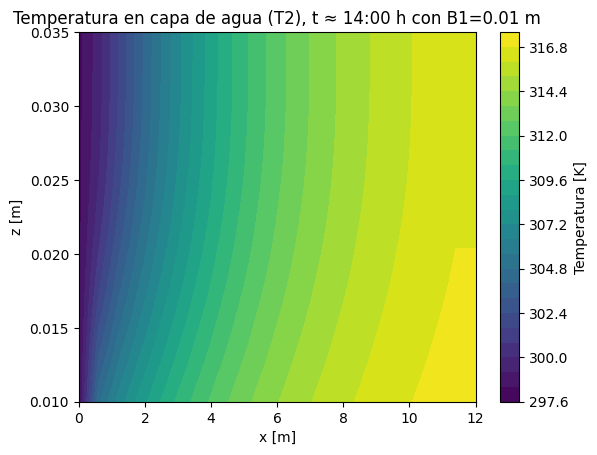

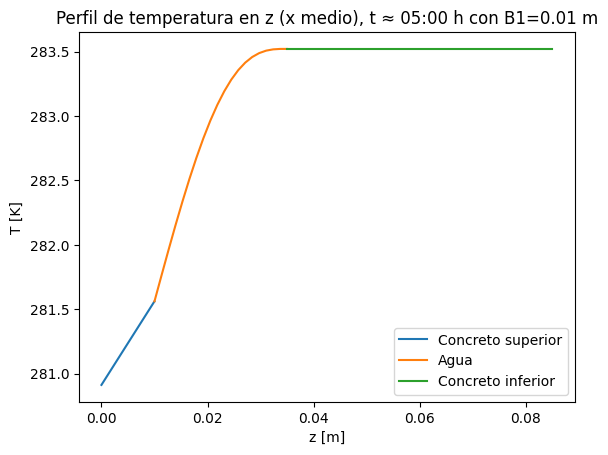

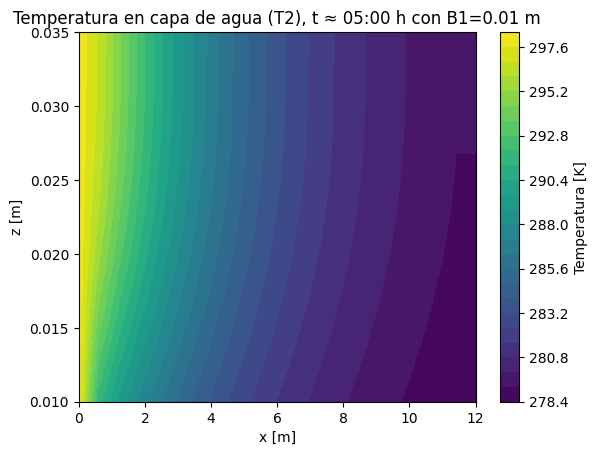

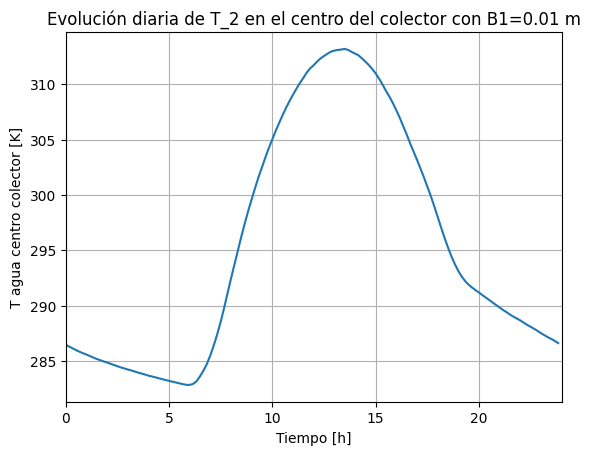

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================
#                    PARÁMETROS DEL MODELO
# ============================================================

#-------------------------------------------------------------
#······················· Geométricos: ························

L = 12          # Largo [m]
B1 = 0.01       # Espesor concreto superior [m]
B2 = 0.025      # Espesor agua [m]
B3 = 0.05       # Espesor concreto inferior [m]

#Conductividades:
k1 = 1.4        # Conductividad concreto [W/m·K]
k2 = 0.6        # Conductividad agua [W/m·K]
k3 = 1.4        # Conductividad concreto [W/m·K]

#Densidades
rho1 = 2400     # Densidad concreto superior (no se usa) Kg/m^3
rho2 = 997      # Densidad agua Kg/m^3
rho3 = 2400     # Densidad concreto inferior (no se usa) Kg/m^3

#Calores específicos:
cp1  = 1000     # Calor especifico concreto superior (no se usa) J/Kg*K
cp2  = 4186     # Calor especifico agua J/Kg*K
cp1  = 1000     # Calor especifico concreto inferior (no se usa) J/Kg*K

#Otros:
v_max = 0.001   # Velocidad máxima agua [m/s]
Tin   = 298.15  # T entrada agua K
h     = 25    # Coef. conveccion aire W/m^2*K
alpha = 0.6     # Absortancia del concreto

#-------------------------------------------------------------
#············ Perfil de velocidad vx(z) parabólico ···········

def v_x_water(z):
    return max(0, 4 * v_max / (B2**2) * (z - B1) * (B1 + B2 - z))

#-------------------------------------------------------------
#············ Parámetros dependientes del tiempo ·············

df = pd.read_csv("G(t)_T(t)_FdT.csv", sep=';', decimal=',')
G_serie = df["G(t)"].values # Flujo solar incidente W/m^2
T_serie = df["T(t) [K]"].values # T ambiente
t_serie = df["t"].values  # fracción de día

dt = 600.0  # segundos = 10 minutos

for n in range(len(G_serie)):
    G = G_serie[n]
    T_inf = T_serie[n]
    t_fisico = n * dt  # otra ocpión sería usar t[n] que sería fracción de día
    # resolver con (G, T_infy, ...)

#PAra más comodidad:
df = df.rename(columns={"G(t)": "G", "T(t) [ºC]": "T_C", "T(t) [K]": "T_K"})
#así se usaría df["G"], df["T_K"] , etc...

#-------------------------------------------------------------
#············ Parámetros para la Foto del sistema ············

# Elegir el instante más cercano a las 14:00 h
t_obj14 =14/24
idx_14 = np.argmin(np.abs(t_serie-t_obj14))
G_14 =G_serie[idx_14]
T_inf_14 = T_serie[idx_14]
# (usaremos G_14 y T_inf_14 más abajo para la foto del sistema a las 14:00 h)

# Elegir el instante más cercano a las 05:00 h (momento sin radiacón y con más frío aprox )
t_obj5 = 5/24
idx_5 = np.argmin(np.abs(t_serie-t_obj5))
G_5 = G_serie[idx_5]
T_inf_5 =T_serie[idx_5]
# (usaremos G_5 y T_inf_5 más abajo para la foto del sistema a las 05:00 h)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#                  DISCRETIZACIÓN DEL MODELO
# ============================================================

#-------------------------------------------------------------
#······················ nodos y mallas ·······················

Nx  = 21
Nz1 = 20
Nz2 = 20
Nz3 = 20

dx = L / (Nx - 1)
dz1 = B1 / (Nz1 - 1)
dz2 = B2 / (Nz2 - 1)
dz3 = B3 / (Nz3 - 1)

x  = np.linspace(0, L, Nx)
z1  = np.linspace(0, B1, Nz1)
z2  = B1 + np.linspace(0, B2, Nz2)
z3  = B1 + B2 + np.linspace(0, B3, Nz3)

# Nodos totales por capa
N1 = Nx * Nz1
N2 = Nx * Nz2
N3 = Nx * Nz3
Ntot = N1 + N2 + N3

def idx1(i, j):
    return i * Nz1 + j
def idx2(i, j):
    return i * Nz2 + j + N1
def idx3(i, j):
    return i * Nz3 + j + N1 + N2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#             Función Para Tener Foto del Sistema
# ============================================================

def resolver_foto(G_val, T_inf_val): # Resuelve el problema estacionario dado cada valor G y T_inf

    G = G_val
    T_inf = T_inf_val

    A = np.zeros((Ntot, Ntot))
    b = np.zeros(Ntot)

    #··········· Capa 1 Cemento ···········
    for i in range(Nx):
        for j in range(1, Nz1 - 1):
            p = idx1(i, j)
            A[p, idx1(i, j+1)] = -k1 / dz1**2
            A[p, idx1(i, j)]   =  2 * k1 / dz1**2
            A[p, idx1(i, j-1)] = -k1 / dz1**2
            b[p] = 0

    for i in range(Nx):
        p = idx1(i, 0)   # nodo z = 0
        coeff_k = k1 / (2 * dz1)
        A[p, idx1(i, 0)] = 3 * coeff_k + h
        A[p, idx1(i, 1)] = -4 * coeff_k
        A[p, idx1(i, 2)] = coeff_k
        b[p] = alpha * G + h * T_inf

    for i in range(Nx):
        p = idx1(i, Nz1-1)     # último nodo capa 1
        A[p, idx1(i, Nz1-1)] = 1
        A[p, idx2(i, 0)]     = -1     # primer nodo capa 2
        b[p] = 0

    #··········· Capa 2 Agua ···········
    for i in range(1, Nx-1):          # interior x
        for j in range(1, Nz2-1):     # interior z
            p = idx2(i, j)
            vz = v_x_water(z2[j])

            #Término depende de la "dirección" de la información, por lo que el término i depnde del termino i-1
            adv    = rho2 * cp2 * vz / dx
            diff_x = k2 / dx**2
            diff_z = k2 / dz2**2

            A[p, idx2(i, j)]   = adv + 2*diff_x + 2*diff_z
            A[p, idx2(i-1, j)] = -adv - diff_x  # Nodo atrás
            A[p, idx2(i+1, j)] = -diff_x        # Nodo adelante
            A[p, idx2(i, j+1)] = -diff_z        # Arriba
            A[p, idx2(i, j-1)] = -diff_z        # Abajo
            b[p] = 0

    # Interfaz Superior
    for i in range(1, Nx):
        p = idx2(i, 0)
        # k1*(T_int - T1_prev)/dz1 + k2*(T_int - T2_next)/dz2 = 0
        A[p, idx2(i, 0)]     = -(k1/dz1 + k2/dz2)
        A[p, idx1(i, Nz1-2)] = k1/dz1
        A[p, idx2(i, 1)]     = k2/dz2
        b[p] = 0

    # Interfaz Inferior
    # CB4: T2(z = B1 + B2) = T3(z = B1 + B2)
    for i in range(Nx):
        p = idx2(i, Nz2-1)   # último nodo capa 2
        A[p, idx2(i, Nz2-1)] = 1
        A[p, idx3(i, 0)]     = -1  # primer nodo capa 3
        b[p] = 0

    # CB5: T2(x=0, z) = Tin
    for j in range(Nz2):
        p = idx2(0, j)
        A[p, :] = 0  #limpiar fila por si las moscas
        A[p, idx2(0, j)] = 1
        b[p] = Tin

    # CB6: dT2/dz = 0 en x = L
    i_out = Nx - 1
    for j in range(1, Nz2-1):
        p = idx2(i_out, j)
        A[p, idx2(i_out, j)]   = 1
        A[p, idx2(i_out-1, j)] = -1
        b[p] = 0

    #··········· Capa 3 Cemento ···········
    for i in range(Nx):
        for j in range(1, Nz3 - 1):
            p = idx3(i, j)
            A[p, idx3(i, j+1)] = -k3 / dz3**2
            A[p, idx3(i, j)]   =  2 * k3 / dz3**2
            A[p, idx3(i, j-1)] = -k3 / dz3**2
            b[p] = 0

    for i in range(Nx):
        p = idx3(i, 0)
        # k2*(T_int - T2_prev)/dz2 + k3*(T_int - T3_next)/dz3 = 0
        A[p, idx3(i, 0)]     = -(k2/dz2 + k3/dz3)
        A[p, idx2(i, Nz2-2)] = k2/dz2
        A[p, idx3(i, 1)]     = k3/dz3
        b[p] = 0


    # CB8: aislamiento en z = B1 + B2 + B3  => dT3/dz = 0
    j_bot = Nz3 - 1
    for i in range(Nx):
        p = idx3(i, j_bot)
        A[p, idx3(i, j_bot)]   = 3
        A[p, idx3(i, j_bot-1)] = -4
        A[p, idx3(i, j_bot-2)] = 1
        b[p] = 0


    # Resolver A T = b en mínimos cuadrados
    T_vec, *_ = np.linalg.lstsq(A, b, rcond=None)

    # T1, T2, T3 en 2D (x,z)
    T1 = np.zeros((Nx, Nz1))
    T2 = np.zeros((Nx, Nz2))
    T3 = np.zeros((Nx, Nz3))

    for i in range(Nx):
        for j in range(Nz1):
            T1[i, j] = T_vec[idx1(i, j)]
        for j in range(Nz2):
            T2[i, j] = T_vec[idx2(i, j)]
        for j in range(Nz3):
            T3[i, j] = T_vec[idx3(i, j)]

    return T1, T2, T3

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#          Foto del Sistema para las 5:00 y las 14:00
# ============================================================

#-------------------------------------------------------------
#············· "Foto" del sistema en t ≈ 14:00 h ·············

#Resolvemos el modelo usando el G y T_inf de las ~14:00 h
T1, T2, T3 = resolver_foto(G_14, T_inf_14)

# Perfiles en z a la mitad del colector
i_mid = Nx // 2

plt.figure()
plt.plot(z1, T1[i_mid, :], label='Concreto superior')
plt.plot(z2, T2[i_mid, :], label='Agua')
plt.plot(z3, T3[i_mid, :], label='Concreto inferior')
plt.xlabel('z [m]')
plt.ylabel('T [K]')
plt.legend()
plt.title('Perfil de temperatura en z (x medio), t ≈ 14:00 h con B1=0.01 m')  #título
plt.show()

# Mapa de temperatura en la capa de agua (T2)
X, Z2 = np.meshgrid(x, z2, indexing='ij')

plt.figure()
cp = plt.contourf(X, Z2, T2, levels=30)
plt.colorbar(cp, label='Temperatura [K]')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.title('Temperatura en capa de agua (T2), t ≈ 14:00 h con B1=0.01 m')  #Título
plt.show()

#-------------------------------------------------------------
#············· "Foto" del sistema en t ≈ 05:00 h ·············

#Resolvemos el modelo usando el G y T_inf de las ~05:00 h
T1, T2, T3 = resolver_foto(G_5, T_inf_5)

# Perfiles en z a la mitad del colector
i_mid = Nx // 2

plt.figure()
plt.plot(z1, T1[i_mid, :], label='Concreto superior')
plt.plot(z2, T2[i_mid, :], label='Agua')
plt.plot(z3, T3[i_mid, :], label='Concreto inferior')
plt.xlabel('z [m]')
plt.ylabel('T [K]')
plt.legend()
plt.title('Perfil de temperatura en z (x medio), t ≈ 05:00 h con B1=0.01 m')  #título
plt.show()

# Mapa de temperatura en la capa de agua (T2)
X, Z2 = np.meshgrid(x, z2, indexing='ij')

plt.figure()
cp = plt.contourf(X, Z2, T2, levels=30)
plt.colorbar(cp, label='Temperatura [K]')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.title('Temperatura en capa de agua (T2), t ≈ 05:00 h con B1=0.01 m')  #Título
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#  Temperatura del agua en el centro del colector vs tiempo
# ============================================================

# Punto representativo: x = L/2, z ≈ mitad de la capa de agua
i_centro = Nx // 2
j_centro = Nz2 // 2

T_centro = np.zeros_like(G_serie)

for n, (G_val, Tinf_val) in enumerate(zip(G_serie, T_serie)):
    T1_foto, T2_foto, T3_foto = resolver_foto(G_val, Tinf_val)
    T_centro[n] = T2_foto[i_centro, j_centro]

t_horas = t_serie * 24

plt.figure()
plt.plot(t_horas, T_centro)
plt.xlabel('Tiempo [h]')
plt.ylabel('T agua centro colector [K]')
plt.title('Evolución diaria de T_2 en el centro del colector con B1=0.01 m')
plt.grid(True)
plt.xlim(0, 24)
plt.show()


Disminuyendo el espesor de la capa de cemento superior  de B1=0.07 m a B1=0.01m.
Aumentando el grosor (diámetro de la tubería del serpentín del colector) de la capa de agua de B2=0,025 m a B2= 0,031 m.

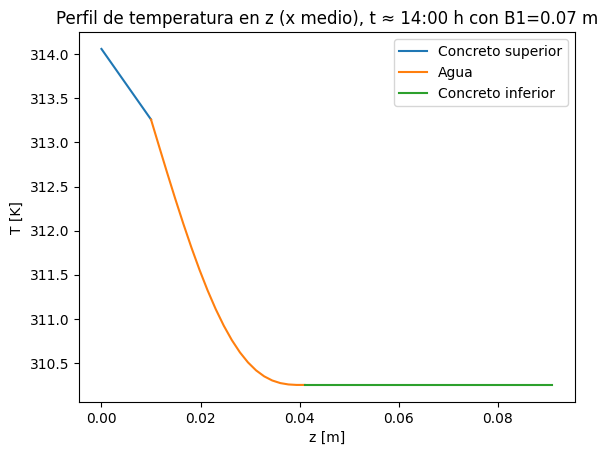

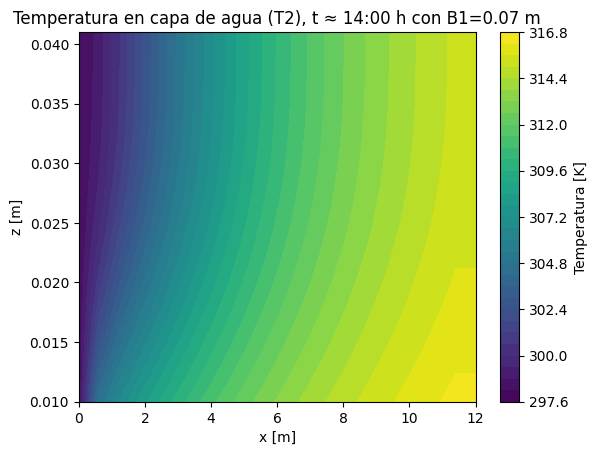

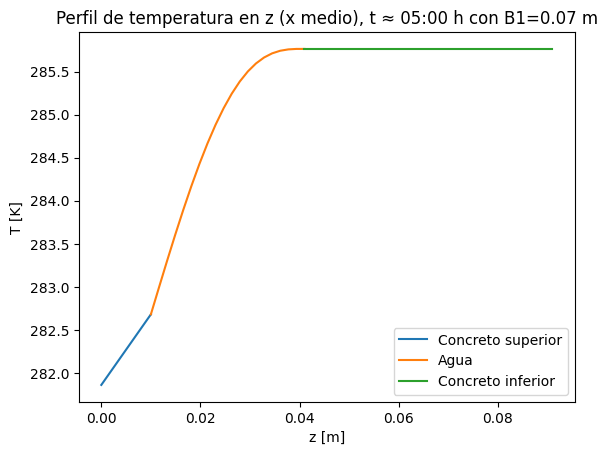

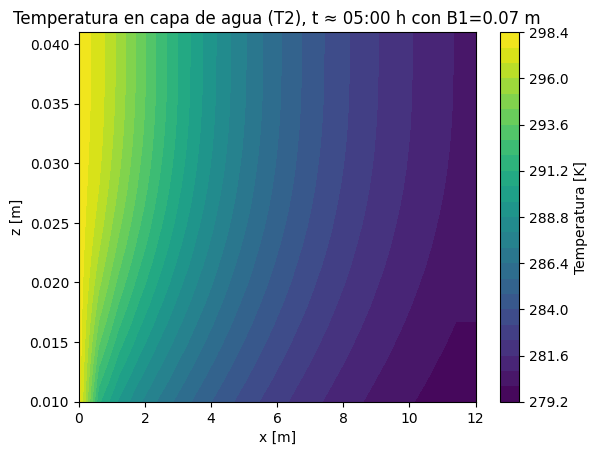

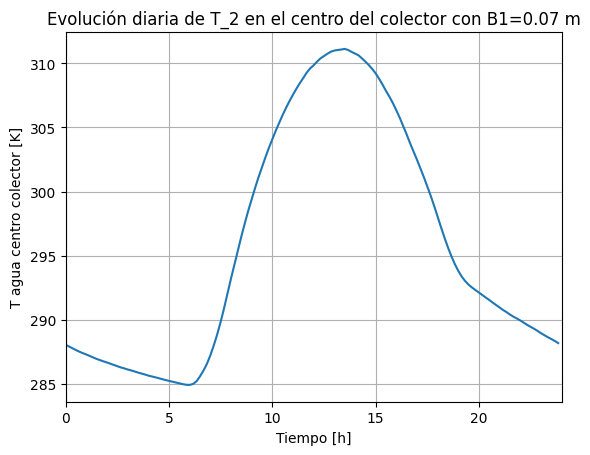

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================
#                    PARÁMETROS DEL MODELO
# ============================================================

#-------------------------------------------------------------
#······················· Geométricos: ························

L = 12          # Largo [m]
B1 = 0.01       # Espesor concreto superior [m]
B2 = 0.031      # Espesor agua [m]
B3 = 0.05       # Espesor concreto inferior [m]

#Conductividades:
k1 = 1.4        # Conductividad concreto [W/m·K]
k2 = 0.6        # Conductividad agua [W/m·K]
k3 = 1.4        # Conductividad concreto [W/m·K]

#Densidades
rho1 = 2400     # Densidad concreto superior (no se usa) Kg/m^3
rho2 = 997      # Densidad agua Kg/m^3
rho3 = 2400     # Densidad concreto inferior (no se usa) Kg/m^3

#Calores específicos:
cp1  = 1000     # Calor especifico concreto superior (no se usa) J/Kg*K
cp2  = 4186     # Calor especifico agua J/Kg*K
cp1  = 1000     # Calor especifico concreto inferior (no se usa) J/Kg*K

#Otros:
v_max = 0.001   # Velocidad máxima agua [m/s]
Tin   = 298.15  # T entrada agua K
h     = 25    # Coef. conveccion aire W/m^2*K
alpha = 0.6     # Absortancia del concreto

#-------------------------------------------------------------
#············ Perfil de velocidad vx(z) parabólico ···········

def v_x_water(z):
    """ACA CAMBIO
    return 4 * v_max / (B2**2) * (z - B1) * (B1 + B2 - z)"""
    return max(0, 4 * v_max / (B2**2) * (z - B1) * (B1 + B2 - z))

#-------------------------------------------------------------
#············ Parámetros dependientes del tiempo ·············

df = pd.read_csv("G(t)_T(t)_FdT.csv", sep=';', decimal=',')
G_serie = df["G(t)"].values # Flujo solar incidente W/m^2
T_serie = df["T(t) [K]"].values # T ambiente
t_serie = df["t"].values  # fracción de día

dt = 600.0  # segundos = 10 minutos

for n in range(len(G_serie)):
    G = G_serie[n]
    T_inf = T_serie[n]
    t_fisico = n * dt  # otra ocpión sería usar t[n] que sería fracción de día
    # resolver con (G, T_infy, ...)

#PAra más comodidad:
df = df.rename(columns={"G(t)": "G", "T(t) [ºC]": "T_C", "T(t) [K]": "T_K"})
#así se usaría df["G"], df["T_K"] , etc...

#-------------------------------------------------------------
#············ Parámetros para la Foto del sistema ············

# Elegir el instante más cercano a las 14:00 h
t_obj14 =14/24
idx_14 = np.argmin(np.abs(t_serie-t_obj14))
G_14 =G_serie[idx_14]
T_inf_14 = T_serie[idx_14]
# (usaremos G_14 y T_inf_14 más abajo para la foto del sistema a las 14:00 h)

# Elegir el instante más cercano a las 05:00 h (momento sin radiacón y con más frío aprox )
t_obj5 = 5/24
idx_5 = np.argmin(np.abs(t_serie-t_obj5))
G_5 = G_serie[idx_5]
T_inf_5 =T_serie[idx_5]
# (usaremos G_5 y T_inf_5 más abajo para la foto del sistema a las 05:00 h)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#                  DISCRETIZACIÓN DEL MODELO
# ============================================================

#-------------------------------------------------------------
#······················ nodos y mallas ·······················

Nx  = 21
Nz1 = 20
Nz2 = 20
Nz3 = 20

dx = L / (Nx - 1)
dz1 = B1 / (Nz1 - 1)
dz2 = B2 / (Nz2 - 1)
dz3 = B3 / (Nz3 - 1)

x  = np.linspace(0, L, Nx)
z1  = np.linspace(0, B1, Nz1)
z2  = B1 + np.linspace(0, B2, Nz2)
z3  = B1 + B2 + np.linspace(0, B3, Nz3)

# Nodos totales por capa
N1 = Nx * Nz1
N2 = Nx * Nz2
N3 = Nx * Nz3
Ntot = N1 + N2 + N3

def idx1(i, j):
    return i * Nz1 + j
def idx2(i, j):
    return i * Nz2 + j + N1
def idx3(i, j):
    return i * Nz3 + j + N1 + N2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#             Función Para Tener Foto del Sistema
# ============================================================

def resolver_foto(G_val, T_inf_val): # Resuelve el problema estacionario dado cada valor G y T_inf

    G = G_val
    T_inf = T_inf_val

    A = np.zeros((Ntot, Ntot))
    b = np.zeros(Ntot)

    #··········· Capa 1 Cemento ···········
    for i in range(Nx):
        for j in range(1, Nz1 - 1):
            p = idx1(i, j)
            A[p, idx1(i, j+1)] = -k1 / dz1**2
            A[p, idx1(i, j)]   =  2 * k1 / dz1**2
            A[p, idx1(i, j-1)] = -k1 / dz1**2
            b[p] = 0

    for i in range(Nx):
        p = idx1(i, 0)   # nodo z = 0
        """ ACA CAMBIO
        T1_0 = idx1(i, 0)
        T1_1 = idx1(i, 1)
        T1_2 = idx1(i, 2)
        A[p, idx1(i, 0)] = 3 * coeff_k + h
        A[p, idx1(i, 1)] = -4 * coeff_k
        A[p, idx1(i, 2)] = coeff_k
        b[p] = alpha * G + h * T_inf """
        coeff_k = k1 / (2 * dz1)
        A[p, idx1(i, 0)] = 3 * coeff_k + h
        A[p, idx1(i, 1)] = -4 * coeff_k
        A[p, idx1(i, 2)] = coeff_k
        b[p] = alpha * G + h * T_inf

    for i in range(Nx):
        p = idx1(i, Nz1-1)     # último nodo capa 1
        A[p, idx1(i, Nz1-1)] = 1
        A[p, idx2(i, 0)]     = -1     # primer nodo capa 2
        b[p] = 0

    #··········· Capa 2 Agua ···········
    for i in range(1, Nx-1):          # interior x
        for j in range(1, Nz2-1):     # interior z
            p = idx2(i, j)
            vz = v_x_water(z2[j])

            #Término depende de la "dirección" de la información, por lo que el término i depnde del termino i-1
            """coeff_ip1 =  rho2 * cp2 * vz / (2 * dx) - k2 / dx**2
            coeff_im1 = -rho2 * cp2 * vz / (2 * dx) - k2 / dx**2
            coeff_ij  =  2 * k2 / dx**2 + 2 * k2 / dz2**2
            coeff_jp1 = -k2 / dz2**2
            coeff_jm1 = -k2 / dz2**2
            A[p, idx2(i+1, j)] = coeff_ip1
            A[p, idx2(i-1, j)] = coeff_im1
            A[p, idx2(i,   j)] = coeff_ij
            A[p, idx2(i, j+1)] = coeff_jp1
            A[p, idx2(i, j-1)] = coeff_jm1
            b[p] = 0"""

            adv    = rho2 * cp2 * vz / dx
            diff_x = k2 / dx**2
            diff_z = k2 / dz2**2

            A[p, idx2(i, j)]   = adv + 2*diff_x + 2*diff_z
            A[p, idx2(i-1, j)] = -adv - diff_x  # Nodo atrás
            A[p, idx2(i+1, j)] = -diff_x        # Nodo adelante
            A[p, idx2(i, j+1)] = -diff_z        # Arriba
            A[p, idx2(i, j-1)] = -diff_z        # Abajo
            b[p] = 0

    """ACA CAMBIO
    for i in range(Nx):
        p = idx2(i, j_top)
        A[p, idx2(i, j_top)]    = 3
        A[p, idx2(i, j_mid)]    = -4
        A[p, idx2(i, j_bottom)] = 2
        b[p] = 0"""
    # Interfaz Superior
    for i in range(1, Nx):
        p = idx2(i, 0)
        # k1*(T_int - T1_prev)/dz1 + k2*(T_int - T2_next)/dz2 = 0
        A[p, idx2(i, 0)]     = -(k1/dz1 + k2/dz2)
        A[p, idx1(i, Nz1-2)] = k1/dz1
        A[p, idx2(i, 1)]     = k2/dz2
        b[p] = 0

    # Interfaz Inferior
    # CB4: T2(z = B1 + B2) = T3(z = B1 + B2)
    for i in range(Nx):
        p = idx2(i, Nz2-1)   # último nodo capa 2
        A[p, idx2(i, Nz2-1)] = 1
        A[p, idx3(i, 0)]     = -1  # primer nodo capa 3
        b[p] = 0

    # CB5: T2(x=0, z) = Tin
    for j in range(Nz2):
        p = idx2(0, j)
        A[p, :] = 0  #limpiar fila por si las moscas
        A[p, idx2(0, j)] = 1
        b[p] = Tin

    # CB6: dT2/dz = 0 en x = L
    i_out = Nx - 1
    """ACA CAMBIO
    j_top    = Nz2 - 1
    j_mid    = Nz2 - 2
    j_bottom = Nz2 - 3 """
    for j in range(1, Nz2-1):
        p = idx2(i_out, j)
        A[p, idx2(i_out, j)]   = 1
        A[p, idx2(i_out-1, j)] = -1
        b[p] = 0

    #··········· Capa 3 Cemento ···········
    for i in range(Nx):
        for j in range(1, Nz3 - 1):
            p = idx3(i, j)
            A[p, idx3(i, j+1)] = -k3 / dz3**2
            A[p, idx3(i, j)]   =  2 * k3 / dz3**2
            A[p, idx3(i, j-1)] = -k3 / dz3**2
            b[p] = 0

    """ACA AÑADIdO:"""
    for i in range(Nx):
        p = idx3(i, 0)
        # k2*(T_int - T2_prev)/dz2 + k3*(T_int - T3_next)/dz3 = 0
        A[p, idx3(i, 0)]     = -(k2/dz2 + k3/dz3)
        A[p, idx2(i, Nz2-2)] = k2/dz2
        A[p, idx3(i, 1)]     = k3/dz3
        b[p] = 0
    """FIN AÑADIDO"""


    # CB8: aislamiento en z = B1 + B2 + B3  => dT3/dz = 0
    """ACA CAMBIO
    j_top    = Nz3 - 1
    j_mid    = Nz3 - 2
    j_bottom = Nz3 - 3
    for i in range(Nx):
        p = idx3(i, 0)
        # k2*(T_int - T2_prev)/dz2 + k3*(T_int - T3_next)/dz3 = 0
        A[p, idx3(i, 0)]     = -(k2/dz2 + k3/dz3)
        A[p, idx2(i, Nz2-2)] = k2/dz2
        A[p, idx3(i, 1)]     = k3/dz3
        b[p] = 0"""
    j_bot = Nz3 - 1
    for i in range(Nx):
        p = idx3(i, j_bot)
        A[p, idx3(i, j_bot)]   = 3
        A[p, idx3(i, j_bot-1)] = -4
        A[p, idx3(i, j_bot-2)] = 1
        b[p] = 0


    # Resolver A T = b en mínimos cuadrados
    T_vec, *_ = np.linalg.lstsq(A, b, rcond=None)

    # T1, T2, T3 en 2D (x,z)
    T1 = np.zeros((Nx, Nz1))
    T2 = np.zeros((Nx, Nz2))
    T3 = np.zeros((Nx, Nz3))

    for i in range(Nx):
        for j in range(Nz1):
            T1[i, j] = T_vec[idx1(i, j)]
        for j in range(Nz2):
            T2[i, j] = T_vec[idx2(i, j)]
        for j in range(Nz3):
            T3[i, j] = T_vec[idx3(i, j)]

    return T1, T2, T3

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#          Foto del Sistema para las 5:00 y las 14:00
# ============================================================

#-------------------------------------------------------------
#············· "Foto" del sistema en t ≈ 14:00 h ·············

#Resolvemos el modelo usando el G y T_inf de las ~14:00 h
T1, T2, T3 = resolver_foto(G_14, T_inf_14)

# Perfiles en z a la mitad del colector
i_mid = Nx // 2

plt.figure()
plt.plot(z1, T1[i_mid, :], label='Concreto superior')
plt.plot(z2, T2[i_mid, :], label='Agua')
plt.plot(z3, T3[i_mid, :], label='Concreto inferior')
plt.xlabel('z [m]')
plt.ylabel('T [K]')
plt.legend()
plt.title('Perfil de temperatura en z (x medio), t ≈ 14:00 h con B1=0.07 m')  #título
plt.show()

# Mapa de temperatura en la capa de agua (T2)
X, Z2 = np.meshgrid(x, z2, indexing='ij')

plt.figure()
cp = plt.contourf(X, Z2, T2, levels=30)
plt.colorbar(cp, label='Temperatura [K]')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.title('Temperatura en capa de agua (T2), t ≈ 14:00 h con B1=0.07 m')  #Título
plt.show()

#-------------------------------------------------------------
#············· "Foto" del sistema en t ≈ 05:00 h ·············

#Resolvemos el modelo usando el G y T_inf de las ~05:00 h
T1, T2, T3 = resolver_foto(G_5, T_inf_5)

# Perfiles en z a la mitad del colector
i_mid = Nx // 2

plt.figure()
plt.plot(z1, T1[i_mid, :], label='Concreto superior')
plt.plot(z2, T2[i_mid, :], label='Agua')
plt.plot(z3, T3[i_mid, :], label='Concreto inferior')
plt.xlabel('z [m]')
plt.ylabel('T [K]')
plt.legend()
plt.title('Perfil de temperatura en z (x medio), t ≈ 05:00 h con B1=0.07 m')  #título
plt.show()

# Mapa de temperatura en la capa de agua (T2)
X, Z2 = np.meshgrid(x, z2, indexing='ij')

plt.figure()
cp = plt.contourf(X, Z2, T2, levels=30)
plt.colorbar(cp, label='Temperatura [K]')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.title('Temperatura en capa de agua (T2), t ≈ 05:00 h con B1=0.07 m')  #Título
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ============================================================
#  Temperatura del agua en el centro del colector vs tiempo
# ============================================================

# Punto representativo: x = L/2, z ≈ mitad de la capa de agua
i_centro = Nx // 2
j_centro = Nz2 // 2

T_centro = np.zeros_like(G_serie)

for n, (G_val, Tinf_val) in enumerate(zip(G_serie, T_serie)):
    T1_foto, T2_foto, T3_foto = resolver_foto(G_val, Tinf_val)
    T_centro[n] = T2_foto[i_centro, j_centro]

t_horas = t_serie * 24

plt.figure()
plt.plot(t_horas, T_centro)
plt.xlabel('Tiempo [h]')
plt.ylabel('T agua centro colector [K]')
plt.title('Evolución diaria de T_2 en el centro del colector con B1=0.07 m')
plt.grid(True)
plt.xlim(0, 24)
plt.show()
